In [1]:
import os.path
import sys

import librosa
import pandas
import numpy
import sklearn.decomposition
import skimage.color

from matplotlib import pyplot as plt
import librosa.display
import seaborn


/usr/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/usr/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/usr/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


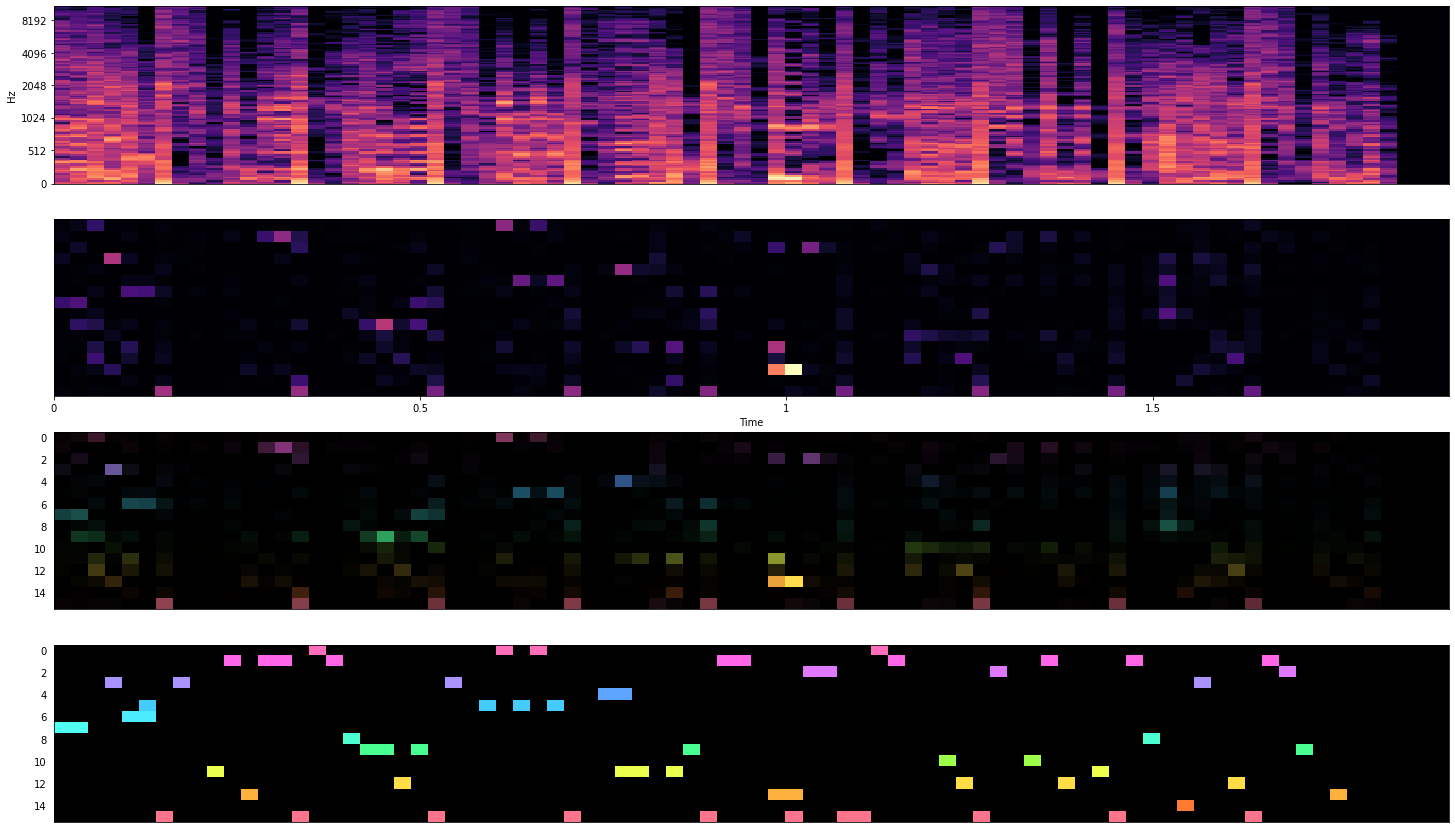

In [12]:

def decompose_audio(y, sr, bpm, per_beat=8,
                    n_components=16, n_mels=128, fmin=200, fmax=6000):
    """
    Decompose audio using NMF spectrogram decomposition,
    using a fixed number of frames per beat (@per_beat) for a given @bpm
    NOTE: assumes audio to be aligned to the beat
    """
    
    interval = (60/bpm)/per_beat
    T = sklearn.decomposition.NMF(n_components)
    S = numpy.abs(librosa.feature.melspectrogram(y, hop_length=int(sr*interval), n_mels=128, fmin=200, fmax=6000))

    comps, acts = librosa.decompose.decompose(S, transformer=T, sort=True)
    return S, comps, acts



def plot_colorized_activations(acts, ax, hop_length=None, sr=None, value_mod=1.0):

    hsv = numpy.stack([
        numpy.ones(shape=acts.shape),
        numpy.ones(shape=acts.shape),
        acts,
    ], axis=-1)

    # Set hue based on a palette
    colors = seaborn.color_palette("husl", hsv.shape[0])
    for row_no in range(hsv.shape[0]):
        c = colors[row_no]
        c = skimage.color.rgb2hsv(numpy.stack([c]))[0]
        hsv[row_no, :, 0] = c[0]
        hsv[row_no, :, 1] = c[1]
        hsv[row_no, :, 2] *= value_mod

    colored = skimage.color.hsv2rgb(hsv)
    
    # use same kind of order as librosa.specshow
    flipped = colored[::-1, :, :]

    ax.imshow(flipped)
    ax.set(aspect='auto')
    
    ax.tick_params(axis='x',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False)
    
    ax.tick_params(axis='both',
        which='both',
        bottom=False,
        left=False,
        top=False,
        labelbottom=False)
    

def plot_activations(S, acts):
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(25, 15), sharex=False)
    
    # spectrogram
    db = librosa.amplitude_to_db(S, ref=numpy.max)
    librosa.display.specshow(db, ax=ax[0], y_axis='mel')

    # original activations
    librosa.display.specshow(acts, x_axis='time', ax=ax[1])

    # colorize
    plot_colorized_activations(acts, ax=ax[2], value_mod=3.0)

    # thresholded
    q = numpy.quantile(acts, 0.90, axis=0, keepdims=True) + 1e-9
    norm = acts / q
    threshold = numpy.quantile(norm, 0.95)
    plot_colorized_activations((norm > threshold).astype(float), ax=ax[3], value_mod=1.0)
    return fig

def main():
    audio_file = 'silence-end.wav'
    audio_bpm = 130
    sr = 22050
    audio, sr = librosa.load(audio_file, sr=sr)
    S, comps, acts = decompose_audio(y=audio, sr=sr, bpm=audio_bpm)
    fig = plot_activations(S, acts)
    fig.savefig('plot.png', transparent=False)
    
main()

In [3]:
r = numpy.expand_dims(numpy.mean(comps, axis=1), axis=1)
#r = comps.T[0]
for c in comps.T:
    rms = sklearn.metrics.mean_squared_error(c, r, squared=True)
    print(rms)

NameError: name 'comps' is not defined

In [ ]:
comps.shape

In [ ]:
def coactivation_matrix(act):
    s = act.shape[0]
    out = numpy.zeros(shape=(s, s))
    
    for col in act.T:
        main = col.argmax(axis=0)
        #print(col.shape, main)
        #for i, val in enumerate(col):
        #out.append({'main': main, 'other': i, 'val': val})
        
        out[main, :] += col
            
    
    #df = pandas.DataFrame.from_records(out)
    out /= act.T.shape[0] 
    
    return out
    #most_active = acts.argmax(axis=0)
    
coact = coactivation_matrix(acts)
#coact.groupby('main')
#coact.pivot(index=['main', 'other'], columns='val')

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharey=True, sharex=True)
upp = numpy.triu(coact, k=1)
seaborn.heatmap(upp, annot=False, fmt='g', ax=ax[0])
ax[0].set_aspect('equal', adjustable='box')

t = numpy.quantile(upp, 0.95)
seaborn.heatmap(upp > t, annot=False, fmt='g', ax=ax[1])
ax[1].set_aspect('equal', adjustable='box')

In [ ]:
acts.shape

In [ ]:
covMatrix.shape

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
covMatrix = numpy.cov(acts, bias=False)
seaborn.heatmap(covMatrix, annot=False, fmt='g', ax=ax)
ax.set_aspect('equal', adjustable='box')

In [ ]:
pca = sklearn.decomposition.PCA(n_components=8)

v = numpy.abs(pca.fit_transform(acts.T).T)
print(v.shape)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(25, 8))
librosa.display.specshow(v, x_axis='time', ax=ax[1])
